###初期コードを読み込み

In [ ]:
!nvidia-smi

Wed Jan  3 14:22:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

base_path = '/content/drive/MyDrive/x_ray_chest/results/ssd'
ver = 'v1'

# 新しいフォルダを生成
weight_folder = 'weight'
train_folder = 'train'
test_folder = 'test'
test_img_folder = 'images'

weight_folder_path = os.path.join(base_path, ver, weight_folder)
train_folder_path = os.path.join(base_path, ver, train_folder)
test_folder_path = os.path.join(base_path, ver, test_folder)
test_img_path = os.path.join(base_path, ver, test_folder, test_img_folder)

In [4]:
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
BBox_List_path = '/content/drive/MyDrive/x_ray_chest/BBox_List_2017.csv'
Data_Entry_path = '/content/drive/MyDrive/x_ray_chest/Data_Entry_2017_v2020.csv'

BBox_List_df = pd.read_csv(BBox_List_path)
Data_Entry_df = pd.read_csv(Data_Entry_path)

In [ ]:
print(BBox_List_df[0:5])

        Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

           h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0   79.186441         NaN         NaN         NaN  
1  313.491525         NaN         NaN         NaN  
2  216.949153         NaN         NaN         NaN  
3   55.322034         NaN         NaN         NaN  
4   78.101695         NaN         NaN         NaN  


In [ ]:
print(Data_Entry_df[0:5])

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                       

In [ ]:
print(len(BBox_List_df))
print(len(BBox_List_df.iloc[:,0].unique()))
print(len(Data_Entry_df))
print(len(Data_Entry_df.iloc[:,0].unique()))

984
880
112120
112120


In [ ]:
data_list = BBox_List_df.merge(Data_Entry_df, on='Image Index', how='inner')
data_list = data_list.set_axis(['img_name', 'label', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'nan1', 'nan2', 'nan3', 'labels', 'follow_up', 'id', 'age', 'gender', 'view_posi', 'ori_img_w', 'ori_img_h', 'pixel_mm_x', 'pixel_mm_y'], axis=1)
data_list = data_list.drop(['nan1', 'nan2', 'nan3', 'labels', 'follow_up', 'id', 'age', 'gender', 'view_posi', 'pixel_mm_x', 'pixel_mm_y'], axis=1)

print(data_list[0:5])

           img_name        label      bbox_x      bbox_y      bbox_w  \
0  00013118_008.png  Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png  Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png  Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png  Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png  Atelectasis  660.067797  569.780787  200.677966   

       bbox_h  ori_img_w  ori_img_h  
0   79.186441       2992       2991  
1  313.491525       3056       2544  
2  216.949153       3056       2544  
3   55.322034       2500       2048  
4   78.101695       2500       2048  


In [ ]:
file_name_list = [i for i in data_list['img_name'].unique()]
print(len(file_name_list))

880


In [ ]:
import torch
from torch.utils.data import Dataset
import sys
import h5py
import matplotlib.pyplot as plt
import cv2

In [ ]:
import torchvision
from torchvision import datasets
from torchvision import transforms

###pytorchモデルの編集を行う場合はsysでパスを通してimport

In [ ]:
#sys.path.append('/content/drive/MyDrive/x_ray_chest/lib/vision-main')
#import my_torchvision
#from my_torchvision import datasets
#from my_torchvision import transforms

In [ ]:
# 画像データをimagesに格納

file_path = '/content/drive/MyDrive/x_ray_chest/file.hdf5'

images = []

with h5py.File(file_path, "r") as f:
    group = f["/images"]

    for i in range(len(file_name_list)):
        file_name = file_name_list[i]

        if file_name in group:
            dataset = group[file_name]
            img_data = np.array(dataset)
            img_tensor = transforms.Compose([transforms.ToTensor()])(img_data)
            images.append(img_tensor)

In [ ]:
boxes = []

for file_name in file_name_list:
    box = []
    row = data_list['img_name'] == file_name
    data = data_list[row]

    for i in range(len(data)):
        lx = data['bbox_x'].iloc[i]
        ly = data['bbox_y'].iloc[i]
        rx = data['bbox_x'].iloc[i] + data['bbox_w'].iloc[i]
        ry = data['bbox_y'].iloc[i] + data['bbox_h'].iloc[i]
        bbox = [lx, ly, rx, ry]
        box.append(bbox)

    box_tensor = torch.tensor(box, dtype = torch.float)

    boxes.append(box_tensor)

In [ ]:
labels = []
label_kind = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']

for file_name in file_name_list:
    label = []
    row = data_list['img_name'] == file_name
    data = data_list[row]

    for i in range(len(data)):
        label_name = data['label'].iloc[i]
        label_index = label_kind.index(label_name)
        label.append(label_index)

    label_tensor = torch.tensor(label, dtype = torch.int64)

    labels.append(label_tensor)

In [ ]:
print(len(images))
print(len(boxes))
print(len(labels))

880
880
880


In [ ]:
dataset = []
for i in range(len(images)):
    data = (images[i], {'boxes':boxes[i], 'labels':labels[i]}, file_name_list[i])
    dataset.append(data)

In [ ]:
train, val, test = torch.utils.data.random_split(dataset=dataset, lengths=[736, 72, 72], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train, batch_size = 1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle=False)

In [ ]:
import torch
import torchvision

label_kind = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']
num_classes = len(label_kind) + 1

model = torchvision.models.detection.ssd300_vgg16(weights = None, num_classes=num_classes)

model

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:02<00:00, 189MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

###mAPの計算（特定のweight）

In [ ]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#
#model.to(device)
#
#model_path = '/content/drive/MyDrive/x_ray_chest/results/ssd/v1/weight/weight_0112.pt'
#model.load_state_dict(torch.load(model_path))
#
#test_results = []
#
#model.eval()
#with torch.no_grad():
#
#    for batch in test_loader:
#        image, target, name = batch
#
#        image = image.to(device)
#
#        predictions = model(image)
#
#        #print(predictions)
#        image = image.cpu()
#        truth_boxes = target['boxes'][0].cpu()
#        truth_labels = target['labels'][0].cpu()
#
#        predict_boxes = predictions[0]["boxes"].cpu()
#        predict_labels = predictions[0]["labels"].cpu()
#        predict_scores = predictions[0]["scores"].cpu()
#
#
#        dict_info = {'image':image, 'truth_boxes':truth_boxes, 'truth_labels':truth_labels, 'file_name':name,
#                     'predict_boxes':predict_boxes, 'predict_labels':predict_labels, 'scores':predict_scores}
#
#        test_results.append(dict_info)
#

In [ ]:
def input_file_generator(test_results, weight_map_path):

    input_path = os.path.join(weight_map_path, 'input')
    result_path = os.path.join(weight_map_path, 'result')
    input_truth_path = os.path.join(input_path, 'truth')
    input_predict_path = os.path.join(input_path, 'predict')

    mkdir_path_list = [weight_map_path, input_path, result_path, input_truth_path, input_predict_path]

    for mkdir_path in mkdir_path_list:
        os.mkdir(mkdir_path)

    for i in range(len(test_results)):
        file_name = str(os.path.splitext(test_results[i]['file_name'][0])[0]) + '.txt'

        with open(os.path.join(input_truth_path, file_name), 'w') as f:

            truth_labels = test_results[i]['truth_labels'].tolist()
            truth_boxes = test_results[i]['truth_boxes'].tolist()

            for j in range(len(truth_labels)):
                row_data = []
                row_data.append(truth_labels[j])
                [row_data.append(box_data) for box_data in truth_boxes[j]]
                row_data = ' '.join(map(str, row_data))
                f.write(row_data + '\n')

    for i in range(len(test_results)):
        file_name = str(os.path.splitext(test_results[i]['file_name'][0])[0]) + '.txt'

        with open(os.path.join(input_predict_path, file_name), 'w') as f:

            truth_labels = test_results[i]['predict_labels'].tolist()
            truth_boxes = test_results[i]['predict_boxes'].tolist()
            scores = test_results[i]['scores'].tolist()

            for j in range(len(truth_labels)):
                row_data = []
                row_data.append(truth_labels[j])
                row_data.append(scores[j])
                [row_data.append(box_data) for box_data in truth_boxes[j]]
                row_data = ' '.join(map(str, row_data))
                f.write(row_data + '\n')

    sh_name = 'map.sh'
    with open(os.path.join(input_path, sh_name), 'w') as f:
        cmd1_row ='cd /content/drive/MyDrive/x_ray_chest/lib/map_tool'
        f.write(cmd1_row + '\n')
        cmd2_row = f'python pascalvoc.py -gt {input_truth_path} -det {input_predict_path} -gtformat xyrb -detformat xyrb -sp {result_path}'
        f.write(cmd2_row + '\n')



In [ ]:
#weight_name = os.path.splitext(os.path.basename(model_path))[0]
#weight_map_path = os.path.join(test_folder_path, weight_name)
#
#input_file_generator(test_results, weight_map_path)

In [ ]:
#import subprocess
#
#os.chmod(os.path.join(weight_map_path, 'input', 'map.sh'), 0o700)
#
#os.chdir(os.path.join(weight_map_path, 'input'))
#subprocess.run(['bash', './map.sh'], text=True)

###mAPを計算（全てのweight）

In [ ]:
import random
import shutil
from PIL import Image, ImageDraw
from torch import tensor
import subprocess


map_path = os.path.join(test_folder_path, 'map')
os.mkdir(map_path)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

weight_dirs = glob(os.path.join(weight_folder_path, 'weight_*'))

for weight_dir in weight_dirs:

    weight_name = os.path.splitext(os.path.basename(weight_dir))[0]

    model.load_state_dict(torch.load(weight_dir))

    test_results = []

    model.eval()
    with torch.no_grad():

        for batch in test_loader:
            image, target, name = batch

            image = image.to(device)

            predictions = model(image)

            #print(predictions)
            image = image.cpu()
            truth_boxes = target['boxes'][0].cpu()
            truth_labels = target['labels'][0].cpu()

            predict_boxes = predictions[0]["boxes"].cpu()
            predict_labels = predictions[0]["labels"].cpu()
            predict_scores = predictions[0]["scores"].cpu()


            dict_info = {'image':image, 'truth_boxes':truth_boxes, 'truth_labels':truth_labels, 'file_name':name,
                         'predict_boxes':predict_boxes, 'predict_labels':predict_labels, 'scores':predict_scores}

            test_results.append(dict_info)


    weight_map_path = os.path.join(map_path, weight_name)

    input_file_generator(test_results, weight_map_path)

    os.chmod(os.path.join(weight_map_path, 'input', 'map.sh'), 0o700)

    os.chdir(os.path.join(weight_map_path, 'input'))
    subprocess.run(['bash', './map.sh'], text=True)


In [6]:
from glob import glob
import re
import pandas as pd
import os

def map_read(pathdir1):

    map_path = os.path.join(test_folder_path, 'map')

    epoch_list = []
    map_value_list = []

    for i in range(len(pathdir1)):

        epoch = i + 1
        epoch_list.append(epoch)

        weight_dir = f'weight_{epoch:04}'
        result_file_path = os.path.join(map_path, weight_dir, 'result', 'results.txt')

        with open(result_file_path, 'r') as f:
            txt_data = f.read()
            pattern = 'mAP: (\d+\.\d+)%'
            map_value = re.findall(pattern, txt_data)
            map_value_list.append(float(map_value[0]))

    map_result_list = [epoch_list, map_value_list]
    map_result_df = pd.DataFrame(map_result_list, index=['epoch', 'map']).T

    map_result_df.to_csv(os.path.join(test_folder_path, 'map.csv'), columns=['epoch', 'map'])

    return map_result_df


     epoch   map
0      1.0  2.77
1      2.0  3.55
2      3.0  3.83
3      4.0  3.49
4      5.0  2.61
..     ...   ...
195  196.0  5.37
196  197.0  6.19
197  198.0  4.54
198  199.0  7.21
199  200.0  4.81

[200 rows x 2 columns]


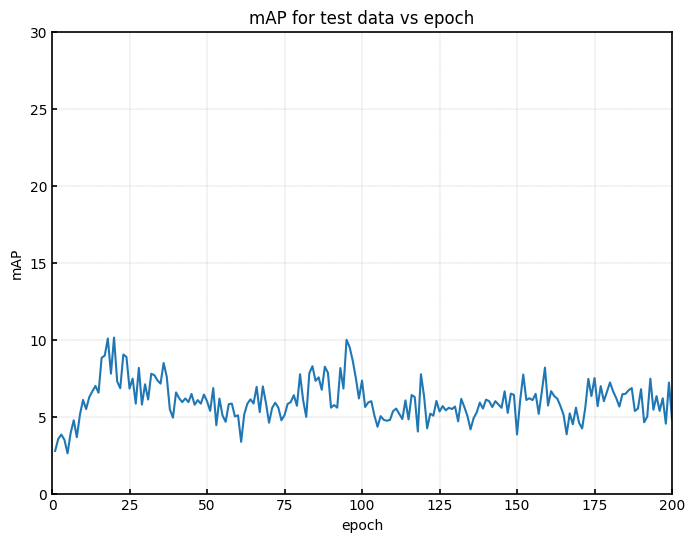

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

pathdir1 = glob('/content/drive/MyDrive/x_ray_chest/results/ssd/v1/test/map/*')

map_result_df = map_read(pathdir1)

print(map_result_df)

     Unnamed: 0  epoch   map
0             0    1.0  2.77
1             1    2.0  3.55
2             2    3.0  3.83
3             3    4.0  3.49
4             4    5.0  2.61
..          ...    ...   ...
195         195  196.0  5.37
196         196  197.0  6.19
197         197  198.0  4.54
198         198  199.0  7.21
199         199  200.0  4.81

[200 rows x 3 columns]


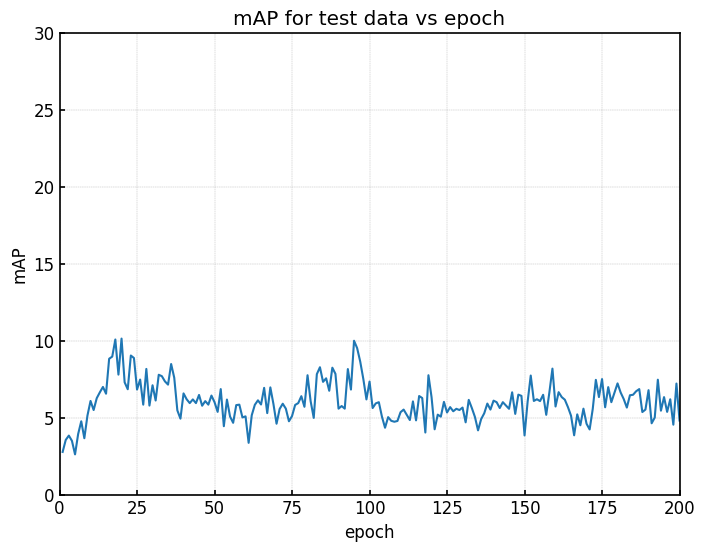

In [12]:
map_csv_path = os.path.join(test_folder_path, 'map.csv')

map_result_df = pd.read_csv(map_csv_path)

print(map_result_df)

plt.rcParams['font.family']= 'sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=True
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = 'black'

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(map_result_df['epoch'], map_result_df['map'])
ax.set_xlim(0, 200)
ax.set_ylim(0, 30)
ax.set_xlabel('epoch')
ax.set_ylabel('mAP')
ax.set_title('mAP for test data vs epoch')

plt.show()

In [14]:
map_csv_path = os.path.join(test_folder_path, 'map.csv')

map_result_df = pd.read_csv(map_csv_path)

map_df = map_result_df['map']
map_df.nlargest(10)

19    10.13
17    10.07
94     9.99
95     9.51
22     9.03
16     8.96
23     8.87
15     8.82
96     8.63
35     8.48
Name: map, dtype: float64